# Estimating Correlated Uncertainty from Fitted Blowers-Masel Trees


For each node in the kinetics rate rule family tree, we want to know how it depends on each training reaction.

<img src="bm_tree_derivative_fig.png" width="500">

Sensitivity S is the relative change in output $y$ over a given relative change in input $x$:
$$S = \frac{\frac{dy}{y}}{\frac{dx}{x}} = \frac{\frac{y_{perturbed} - y}{y}}{\frac{x_{perturbed} - x}{x}} $$

$$S = \frac{dy}{dx}\cdot \frac{x}{y} $$

Define the scale factor $a$:
$$x_{perturbed} = ax$$

$$x_{perturbed} = (a-1)x + x$$

$$x_{perturbed} - x = (a-1)x$$

$$\frac{x_{perturbed} - x}{x} = a - 1$$

$$\frac{dx}{x} = a - 1$$

$$S = \frac{\frac{dy}{y}}{a - 1}$$

$$S = \frac{d\ln(y)}{a - 1}$$

In [1]:
import json

from rmgpy.molecule.molecule import *
from rmgpy.species import *
from rmgpy.data.rmg import RMGDatabase
from rmgpy.species import Species
from rmgpy import settings

import rmgpy
from rmgpy import chemkin
import numpy as np
from copy import deepcopy
import csv
from rmgpy.molecule.molecule import *
from rmgpy.species import *
from rmgpy.chemkin import *
import rmgpy.kinetics as _kinetics
from rmgpy.data.rmg import RMGDatabase
from IPython.display import display
from rmgpy.data.thermo import ThermoLibrary
from rmgpy.rmg.react import react
from rmgpy.species import Species
from rmgpy.reaction import Reaction
from rmgpy.data.rmg import get_db
from rmgpy.exceptions import UndeterminableKineticsError, ActionError
from rmgpy.data.base import LogicOr
from itertools import product
from rmgpy.molecule.group import Group
from rmgpy.kinetics.arrhenius import ArrheniusBM
import time
import scipy.special as special
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

In [2]:
## Load the database
database = RMGDatabase()
database.load(path=settings['database.directory'],
              thermo_libraries=['Klippenstein_Glarborg2016', 'BurkeH2O2', 'thermo_DFT_CCSDTF12_BAC',
                                'DFT_QCI_thermo', 'primaryThermoLibrary', 'primaryNS', 'NitrogenCurran',
                                'NOx2018', 'FFCM1(-)', 'SulfurLibrary', 'SulfurGlarborgH2S', 'SABIC_aromatics'],
              transport_libraries=[],
              reaction_libraries=[],
              seed_mechanisms=[],  # ['BurkeH2O2inN2','ERC-FoundationFuelv0.9'],
              kinetics_families='all',
              kinetics_depositories=['training'],
              depository=False,  # Don't bother loading the depository information, as we don't use it
              )

In [3]:
## Make the kinetics rate rule tree

family = database.kinetics.families["Singlet_Carbene_Intra_Disproportionation"]
family.clean_tree()

family.generate_tree(thermo_database=database.thermo,
                     nprocs=1,
                     new_fraction_threshold_to_reopt_node=0.25,
                     max_batch_size=800,
                     extension_iter_max=2,
                     extension_iter_item_cap=100)

print(f"Group Entries: {len(family.groups.entries)}")
family.check_tree()
family.regularize(thermo_database=database.thermo)
templateRxnMap = family.get_reaction_matches(thermo_database=database.thermo, remove_degeneracy=True,
                                             get_reverse=True, exact_matches_only=False, fix_labels=True)

family.clean_tree_rules()
family.make_bm_rules_from_template_rxn_map(templateRxnMap, compute_derivatives=True)

ERROR:root:4.0
ERROR:root:iter_max achieved terminating early
ERROR:root:iter_max achieved terminating early
ERROR:root:iter_max achieved terminating early


Group Entries: 7


/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [4]:
## unpack the sensitivites
derivatives = {}
for key in family.rules.entries.keys():
    entry = family.rules.entries[key]
    
    if len(entry) == 0:
        derivatives[key] = []
        continue
    entry = entry[0]
    print(entry.long_desc)
    start_str = 'sensitivities = '
    start_index = entry.long_desc.find(start_str) + len(start_str)
    sensitivities_str = entry.long_desc[start_index:].replace("'", '"')
    derivatives[key] = json.loads(sensitivities_str)

BM rule fitted to 4 training reactions at node Root
Total Standard Deviation in ln(k): 10.36278215827023
sensitivities = [{'dA': 1.8261705171113347, 'dE0': 0.01614129151255035, 'dn': 0.10296844515154145, 'name': 'C6H6 <=> C6H6-2'}, {'dA': -5413.556724249416, 'dE0': -99.23615237168131, 'dn': -355.2462699571583, 'name': 'C6H6-3 <=> C6H6-4'}, {'dA': -6.7003636370777935, 'dE0': -0.07114290936806947, 'dn': -0.45360352147960353, 'name': '[C]1C=CC=CC1 <=> C6H6-5'}, {'dA': -4.169007026724355, 'dE0': -0.04522559674290594, 'dn': -0.28836856258954496, 'name': '[C]1C=CCC=C1 <=> C6H6-7'}]
BM rule fitted to 2 training reactions at node Root_Ext-3C-R_Ext-4R!H-R_Sp-4R!H-1C
Total Standard Deviation in ln(k): 9.762079318807448
sensitivities = [{'dA': 0.4975766477373962, 'dE0': -37.666938775510175, 'dn': -2.9668649057030526e-06, 'name': 'C6H6 <=> C6H6-2'}, {'dA': 0.4975143957435253, 'dE0': -98.40868274582552, 'dn': 1.0933643724307169e-07, 'name': 'C6H6-3 <=> C6H6-4'}]
BM rule fitted to 2 training reactio

In [5]:
# list the training reactions
for key in family.rules.entries.keys():
    entry = family.rules.entries[key]
    if len(entry) == 0:
        continue
    print(entry[0])
    for i, rxn in enumerate(templateRxnMap[key]):
        print('\t', rxn, f'\tdA_node/dA_train=', derivatives[key][i]['dA'], derivatives[key][i]['dE0'], derivatives[key][i]['dn'])  # derivatives[key][i]['name'])

Root
	 C6H6 <=> C6H6-2 	dA_node/dA_train= 1.8261705171113347 0.01614129151255035 0.10296844515154145
	 C6H6-3 <=> C6H6-4 	dA_node/dA_train= -5413.556724249416 -99.23615237168131 -355.2462699571583
	 [C]1C=CC=CC1 <=> C6H6-5 	dA_node/dA_train= -6.7003636370777935 -0.07114290936806947 -0.45360352147960353
	 [C]1C=CCC=C1 <=> C6H6-7 	dA_node/dA_train= -4.169007026724355 -0.04522559674290594 -0.28836856258954496
Root_Ext-3C-R_Ext-4R!H-R_Sp-4R!H-1C
	 C6H6 <=> C6H6-2 	dA_node/dA_train= 0.4975766477373962 -37.666938775510175 -2.9668649057030526e-06
	 C6H6-3 <=> C6H6-4 	dA_node/dA_train= 0.4975143957435253 -98.40868274582552 1.0933643724307169e-07
Root_Ext-3C-R_Ext-4R!H-R_N-Sp-4R!H-1C
	 [C]1C=CC=CC1 <=> C6H6-5 	dA_node/dA_train= 0.4975058626563107 -290.49750617627717 2.14567924307973e-07
	 [C]1C=CCC=C1 <=> C6H6-7 	dA_node/dA_train= 349.3106865329214 -857.935978585093 -6.573177137174851
Root_Ext-3C-R_Ext-4R!H-R_Sp-4R!H-1C_Ext-4R!H-R_Ext-4R!H-R
	 C6H6 <=> C6H6-2 	dA_node/dA_train= 0.99503308531687

## Try to visualize the fitting

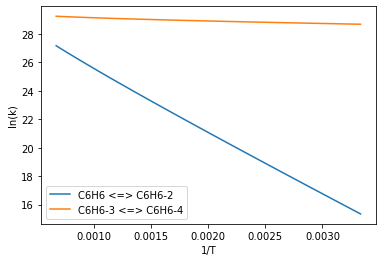

In [33]:
import matplotlib.pyplot as plt
# Plot ln(k) vs 1/T

# Try this node first because it makes the most sense
#Root_Ext-3C-R_Ext-4R!H-R_Sp-4R!H-1C
# C6H6 <=> C6H6-2 	dA_node/dA_train= 0.4975766477373962 -37.666938775510175 -2.9668649057030526e-06
# C6H6-3 <=> C6H6-4 	dA_node/dA_train= 0.4975143957435253 -98.40868274582552 1.0933643724307169e-07

# Get this training reaction C6H6 <=> C6H6-2
node_name = 'Root_Ext-3C-R_Ext-4R!H-R_Sp-4R!H-1C'

R = 1.98720425864083E-3
Tmin = 300
Tmax = 1500
legend = []
for training_rxn in templateRxnMap[node_name]:
    legend.append(str(training_rxn))
    A = training_rxn.kinetics.A.value
    Ea = training_rxn.kinetics.Ea.value
    n = training_rxn.kinetics.n.value
    if training_rxn.kinetics.Ea.units != 'kcal/mol':
        print('Error: wrong units!')
        print(training_rxn.kinetics.Ea.units)

    
    T = np.linspace(Tmin, Tmax, 100)
    T_inv = 1.0 / T
    lnk = np.log(A * np.multiply(np.float_power(T, n), np.exp(-Ea/(R*T))))
    plt.plot(T_inv, lnk)

plt.ylabel('ln(k)')
plt.xlabel('1/T')
plt.legend(legend)
plt.show()

In [30]:
templateRxnMap[node_name][0].kinetics.Ea.value

8.03

In [ ]:
templateRxnMap['Root'][1]

In [ ]:
family.rules.entries

In [ ]:
family.groups.entries['Root_Ext-3C-R_Ext-4R!H-R_Sp-4R!H-1C'].item